# Features Selection: Scikit Learn

Collection of features selection techniques provided by Scikit Learn:

In [4]:
%matplotlib inline
import sys
sys.path.append('../../')  
from tools.reader import csv2df as reader
from preprocessing.transformation import launch_numerical as transformer
from preprocessing.scalers import normalization
from tools.columns import num2cal
from models.metrics import metrics_regression
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import copy

### arguments

In [5]:
path_input = '../../../datasets/dataset.solar.csv'
ncv = 5
njobs = -1

### load data

In [26]:
# read
ddt = {'lcol':['dt'], 'sformat': '%Y-%m-%d %H:%M:%S'}
data, dcol = reader(path_input, lindex = ['dt'], ltarget = ['ghi'], ddt = ddt)
# filter (only hforecast = 0 - 23h)
data = data[data.hforecast<24]
# display
print('shape',data.shape)
print('period: %s - %s'%(data.index.tolist()[0], data.index.tolist()[-1]))
print('X: %s'%dcol['lx'])
print('y: %s'%dcol['ly'])

shape (25211, 14)
period: 2013-01-01 09:00:00 - 2016-01-02 11:00:00
X: ['hforecast', 'VGRD267', 'UGRD267', 'LCDC267', 'MCDC267', 'HCDC267', 'TCDC267', 'PRES267', 'RH267', 'TMP267', 'APCP267', 'doy', 'hour']
y: ['y']


### pre-processing

In [10]:
# X
X = transformer(data[dcol['lx']])
# y
#scaler = normalization.Scaler()
#y = scaler.fit_transform(data[dcol['ly']]).ravel()
y = transformer(data[dcol['ly']]).ravel()

In [11]:
# y: numerical to categorical
nlabels = 10
lbins = list(np.linspace(np.min(data.y.values), np.max(data.y.values), num=nlabels+1))
llabels = list(range(nlabels))
cy = np.array(num2cal(data, 'y', lbins, llabels)['cy'].values)

In [12]:
# create samples
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=0.3, random_state=0)
X_train, X_test, cy_train, cy_test =\
    train_test_split(X, cy, test_size=0.3, random_state=0, stratify=cy)

## ElasticNet (Regression)

- Optimal alpha: 1.34677358
- Optimal l1_ratio: 0.000
- Number of iterations 8


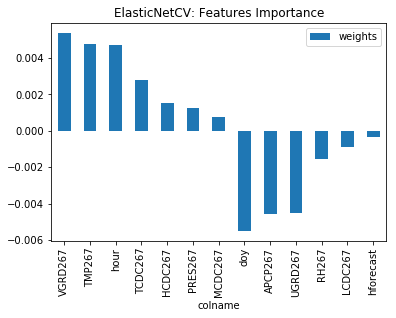

In [13]:
from sklearn.linear_model import ElasticNetCV

# regressor: ElasticNetCV (for tuning hyperparameters)
estimatorcv = ElasticNetCV(l1_ratio=[.0001, .001 , .1, .5, .7, .9, .95, 1], eps=0.001, n_alphas=100, fit_intercept=True, 
                        normalize=False, precompute='auto', max_iter=5000, tol=0.0001, cv=ncv, 
                        copy_X=True, verbose=0, n_jobs=njobs, positive=False, random_state=None, selection='cyclic')
estimatorcv.fit(X_train, y_train)
print('- Optimal alpha: %.8f'%estimatorcv.alpha_)
print('- Optimal l1_ratio: %.3f'%estimatorcv.l1_ratio_)
print('- Number of iterations %d'%estimatorcv.n_iter_)
# plot features importance
import matplotlib.pyplot as plt
dfw = pd.DataFrame(np.c_[dcol['lx'],np.array(estimatorcv.coef_)], columns = ['colname','weights']).sort_values(['weights'], ascending=[0]).set_index('colname')
dfw['weights'] = dfw['weights'].astype('float')
dfw.plot(kind='bar',title='ElasticNetCV: Features Importance')
plt.show()

## Sequential feature selection algorithms (Classification)

In [14]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

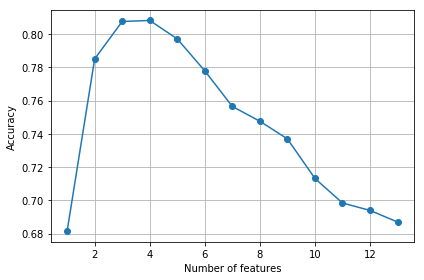

In [15]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

# selecting features
sbs = SBS(knn, k_features=1)
sbs.fit(X, cy)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
#plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()

In [16]:
k3 = list(sbs.subsets_[10])
print(data[dcol['lx']].columns[:][k3])

Index(['hforecast', 'APCP267', 'doy'], dtype='object')


In [17]:
knn.fit(X_train, cy_train)
print('Training accuracy:', knn.score(X_train, cy_train))
print('Test accuracy:', knn.score(X_test, cy_test))

Training accuracy: 0.756842522808
Test accuracy: 0.682178741407


In [18]:
knn.fit(X_train[:, k3], cy_train)
print('Training accuracy:', knn.score(X_train[:, k3], cy_train))
print('Test accuracy:', knn.score(X_test[:, k3], cy_test))

Training accuracy: 0.858049526832
Test accuracy: 0.813590692755


## Assessing feature importance with Random Forests (Classification)

 1) hforecast                      0.207625
 2) hour                           0.174742
 3) doy                            0.105917
 4) TMP267                         0.078163
 5) RH267                          0.068527
 6) VGRD267                        0.066126
 7) PRES267                        0.061606
 8) UGRD267                        0.058540
 9) TCDC267                        0.041683
10) APCP267                        0.040330
11) MCDC267                        0.035679
12) HCDC267                        0.031383
13) LCDC267                        0.029680


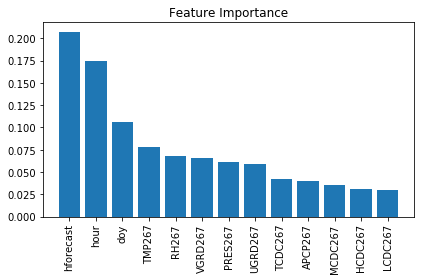

In [19]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = data[dcol['lx']].columns

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1, n_jobs = -1)

forest.fit(X_train, cy_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
#plt.savefig('images/04_09.png', dpi=300)
plt.show()

## Assessing feature importance with Random Forests (Regression)

 1) UGRD267                        0.120429
 2) PRES267                        0.117334
 3) VGRD267                        0.116609
 4) RH267                          0.115512
 5) TMP267                         0.110175
 6) doy                            0.070331
 7) TCDC267                        0.059857
 8) MCDC267                        0.051971
 9) HCDC267                        0.050433
10) hour                           0.049712
11) APCP267                        0.047615
12) hforecast                      0.047493
13) LCDC267                        0.042529


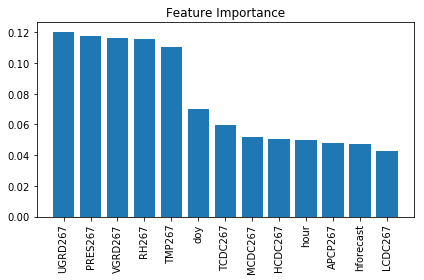

In [20]:
from sklearn.ensemble import RandomForestRegressor

feat_labels = data[dcol['lx']].columns

forest = RandomForestRegressor(n_estimators=500,
                                random_state=1, n_jobs = -1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
#plt.savefig('images/04_09.png', dpi=300)
plt.show()

## Using theBuilt-in XGBoost Feature Importance Plot (Classification)

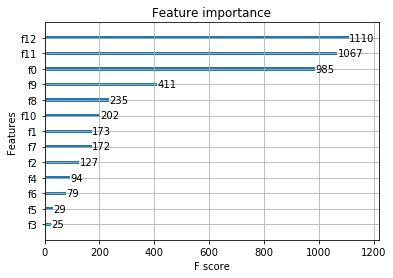

      colname            importance
id                                 
12       hour   0.23571883141994476
11        doy   0.22658738493919373
0   hforecast   0.20917391777038574
9      TMP267   0.08727967739105225
8       RH267  0.049904439598321915
10    APCP267    0.0428965799510479
1     VGRD267  0.036738160997629166
7     PRES267  0.036525800824165344
2     UGRD267  0.026969632133841515
4     MCDC267  0.019961776211857796
6     TCDC267   0.01677638478577137
5     HCDC267  0.006158419884741306
3     LCDC267  0.005308982916176319


In [21]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
# fit model no training data
model = XGBClassifier()
model.fit(X_train, cy_train)
# plot feature importance
plot_importance(model)
pyplot.show()
# importance df
dfimportance = pd.DataFrame(np.c_[np.arange(len(dcol['lx'])),np.array(dcol['lx']),model.feature_importances_],columns=['id','colname','importance']).set_index('id').sort_values(['importance'], ascending=[0])
print(dfimportance)

In [22]:
model.fit(X_train, cy_train)
print('Training accuracy:', model.score(X_train, cy_train))
print('Test accuracy:', model.score(X_test, cy_test))

Training accuracy: 0.781265937553
Test accuracy: 0.767451084082


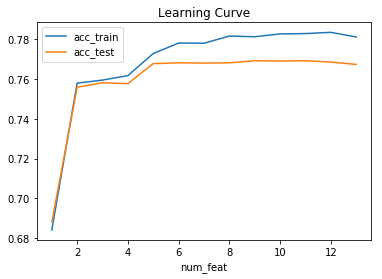

In [23]:
## LEARNING CURVE
lindex = [int(i) for i in dfimportance.index.tolist()]
lacc_train = list()
lacc_test = list()
for ii in list(range(1,len(lindex)+1,1)):
    model.fit(X_train[:,lindex[:ii]], cy_train)
    lacc_train.append(model.score(X_train[:,lindex[:ii]], cy_train))
    lacc_test.append(model.score(X_test[:,lindex[:ii]], cy_test))
dfacc = pd.DataFrame(list(zip(list(range(1,len(lindex)+1,1)), lacc_train, lacc_test)), columns = ['num_feat','acc_train','acc_test']).set_index('num_feat')
dfacc.plot(title="Learning Curve")

## Using theBuilt-in XGBoost Feature Importance Plot (Regression)

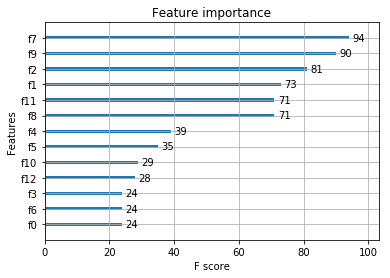

      colname            importance
id                                 
7     PRES267   0.13762810826301575
9      TMP267   0.13177159428596497
2     UGRD267   0.11859443783760071
1     VGRD267   0.10688140243291855
8       RH267   0.10395314544439316
11        doy   0.10395314544439316
4     MCDC267   0.05710102617740631
5     HCDC267   0.05124450847506523
10    APCP267   0.04245973750948906
12       hour  0.040995609015226364
0   hforecast  0.035139091312885284
3     LCDC267  0.035139091312885284
6     TCDC267  0.035139091312885284


In [24]:
from xgboost import XGBRegressor
from xgboost import plot_importance
from matplotlib import pyplot
# fit model no training data
model = XGBRegressor()
model.fit(X_train, y_train)
# plot feature importance
plot_importance(model)
pyplot.show()
# importance df
dfimportance = pd.DataFrame(np.c_[np.arange(len(dcol['lx'])),np.array(dcol['lx']),model.feature_importances_],columns=['id','colname','importance']).set_index('id').sort_values(['importance'], ascending=[0])
print(dfimportance)

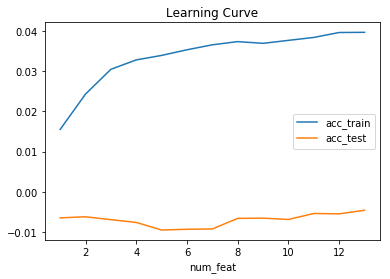

In [25]:
## LEARNING CURVE
lindex = [int(i) for i in dfimportance.index.tolist()]
lacc_train = list()
lacc_test = list()
for ii in list(range(1,len(lindex)+1,1)):
    model.fit(X_train[:,lindex[:ii]], y_train)
    lacc_train.append(model.score(X_train[:,lindex[:ii]], y_train))
    lacc_test.append(model.score(X_test[:,lindex[:ii]], y_test))
dfacc = pd.DataFrame(list(zip(list(range(1,len(lindex)+1,1)), lacc_train, lacc_test)), columns = ['num_feat','acc_train','acc_test']).set_index('num_feat')
dfacc.plot(title="Learning Curve")